In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D      
from scipy import stats 
from scipy.optimize import leastsq

### Load data

In [15]:
# ms data
data = pd.read_csv('data/cas_intensities.csv', delimiter=',', index_col = 0)
# only use first repliate
data = data[data["replicate"]==1]
ms_data_original = data.drop(columns=["replicate"])
ms_data = ms_data_original.copy()
ms_data = ms_data.apply(lambda row: row/row.mean(),axis=1)
ms_data = stats.zscore(np.log(ms_data))

# panelist data
panelist_data_df = pd.read_table("data/vlb_data_combined.txt", delimiter=',', index_col = 1)
panelist_data_df = panelist_data_df[panelist_data_df["panelist"]==1]
panelist_data_df = panelist_data_df.drop(columns=["panelist", "date"])

# get only comparable samplekeys = 197 samples
valid_indexes = [index for index in panelist_data_df.index if index in ms_data.index]
ms_data_comp = ms_data.loc[valid_indexes]
panelist_data_comp = panelist_data_df.loc[valid_indexes]

# flavors 
flavors = ['Floral','Fruity','Woody','Complexity','Malt','Sweet','Peaty','Dried_fruits','Aftertaste']

# find CAS number to each molecule
CAS_to_mol = pd.read_table("data/CAS_mol_OD.csv", delimiter=',',  names= ["CAS","intensity", "odor"])
CAS_to_mol=CAS_to_mol.drop(columns=["intensity","odor"])
CAS_to_mol= CAS_to_mol.drop_duplicates()

c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


### Predictive Models 
#### Linear Regression

In [4]:
panelist_df_norm = stats.zscore(panelist_data_comp)

In [5]:
def find_best_params(x, y):
    x=np.nan_to_num(x)
    def score( p, x,y):
        prediction = np.dot(x,p)
        #print(prediction)
        #print(np.sum(np.abs(prediction-y)))
        return np.hstack((prediction-y,p))
    
    p0=np.ones(np.shape(x)[1])
    p1 = leastsq(score, p0,(x,y),epsfcn=1)[0]
    
    prediction = np.dot(p1,x.T)
    return(p1,prediction)

In [6]:
# fin params for predictiopn
p_sweet, prediction_sweet= find_best_params(np.array( ms_data_comp ),np.array(panelist_df_norm['Sweet']))
p_fruity,prediction_fruity= find_best_params(np.array( ms_data_comp ),np.array(panelist_df_norm['Fruity']))
p_woody,prediction_woody= find_best_params(np.array( ms_data_comp ),np.array(panelist_df_norm['Woody']))
p_malt,prediction_malt= find_best_params(np.array( ms_data_comp ),np.array(panelist_df_norm['Malt']))
p_floral, prediction_floral= find_best_params(np.array( ms_data_comp ),np.array(panelist_df_norm['Floral']))
p_peaty, prediction_peaty= find_best_params(np.array( ms_data_comp ),np.array(panelist_df_norm['Peaty']))
p_driedfruits,prediction_dried_fruits= find_best_params(np.array( ms_data_comp ),np.array(panelist_df_norm['Dried_fruits']))
p_complex,prediction_complexity= find_best_params(np.array( ms_data_comp ),np.array(panelist_df_norm['Complexity']))
p_aftertaste, prediction_aftertaste= find_best_params(np.array( ms_data_comp ),np.array(panelist_df_norm['Aftertaste']))


In [9]:
samples = list(ms_data_comp['100-51-6'].index)

In [10]:
def show_correlation_pred_extend(prediction,reference,flavor):

    true_pos = (reference>0) & (prediction>0)
    true_neg = (reference<=0) & (prediction<=0)
  

    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)

    for i, sample in enumerate(samples):
        plt.plot(['reference','prediction'], [reference[i],prediction[i]], color='#7f7fff', marker='o', markersize=5)

    ticks = plt.xticks(['reference','prediction'])
    yl = plt.ylim(-3.5,3.5)

    plt.ylabel('flavor score')
    
    plt.subplot(1,3,2)

    plt.hist(reference, color ='g', alpha = 0.5)
    plt.hist(prediction, alpha=0.5, color ='b')
    
    plt.xlim(-3.5, 3.5)
    plt.ylim(0, 130)
    
    labels= ["reference","prediction"]
    plt.legend(labels)

    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    
    plt.subplot(1,3,3)
    plt.plot(prediction,reference,"o", color='b', alpha =0.5)
    
    plt.title("Correlation: "+ str(round(np.corrcoef(np.array(prediction), reference)[0,1],4)))
    
    plt.xlim(-3.5,3.5)
    plt.ylim(-4,4)

    plt.suptitle(flavor)

     # Add text next to the plot
    text = ('True positive rate: ',
            round(np.sum(true_pos==True)/np.sum(prediction>0),4), '\nTrue negative rate: ', round(np.sum(true_neg==True)/np.sum(prediction<=0),4))


    plt.text(4, 0, '\n'.join(map(str, text)), fontsize=12, va='bottom', color='black')

    plt.show()

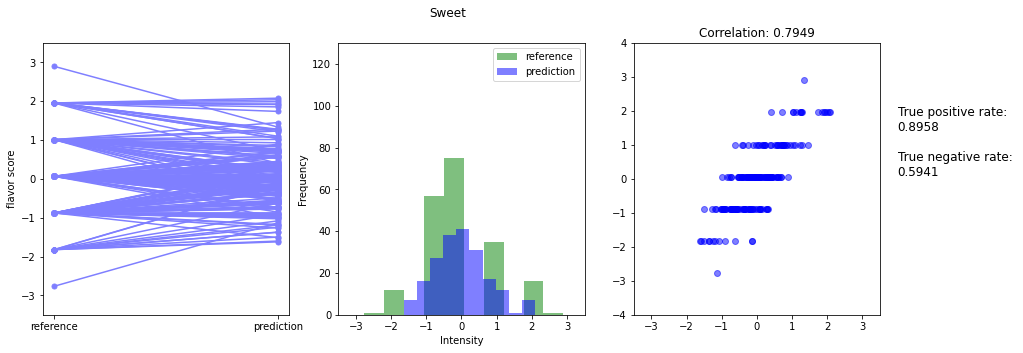

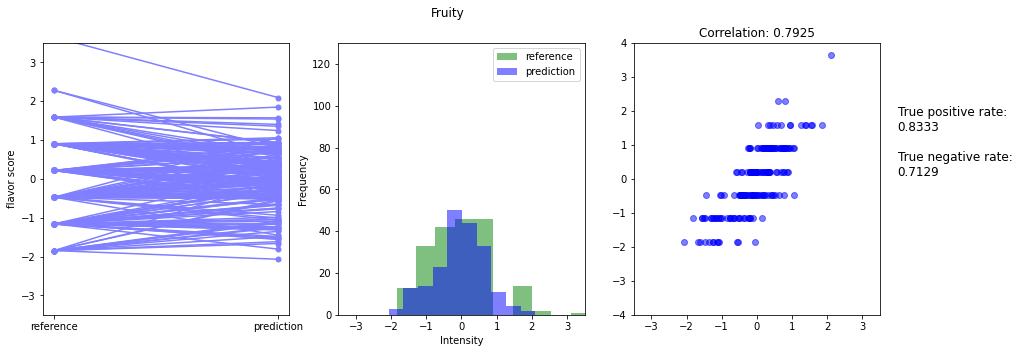

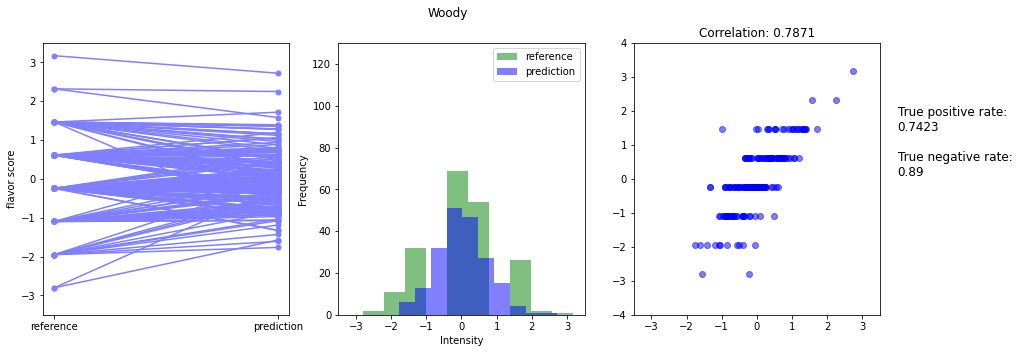

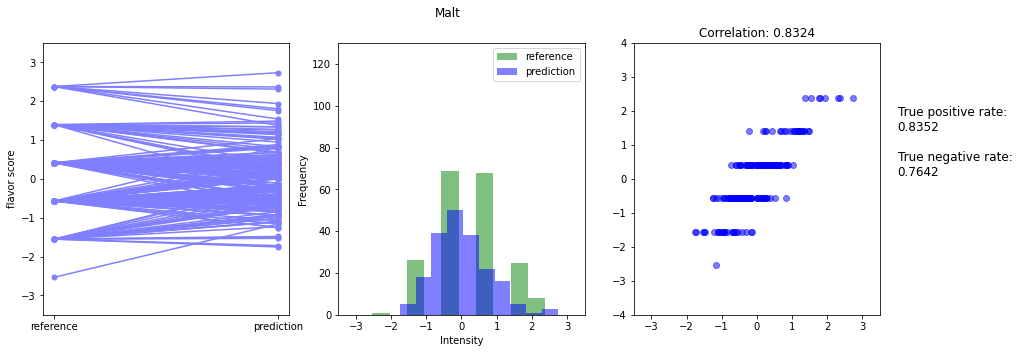

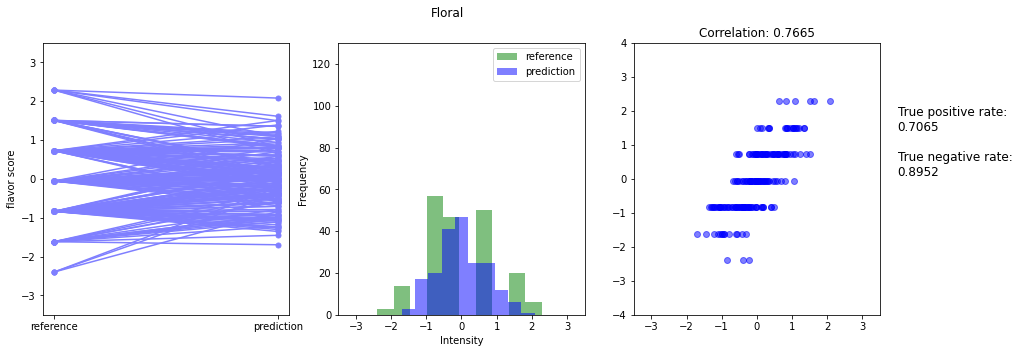

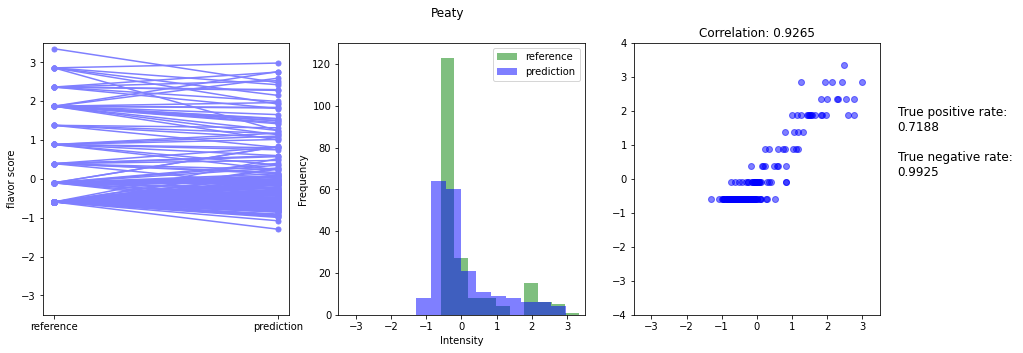

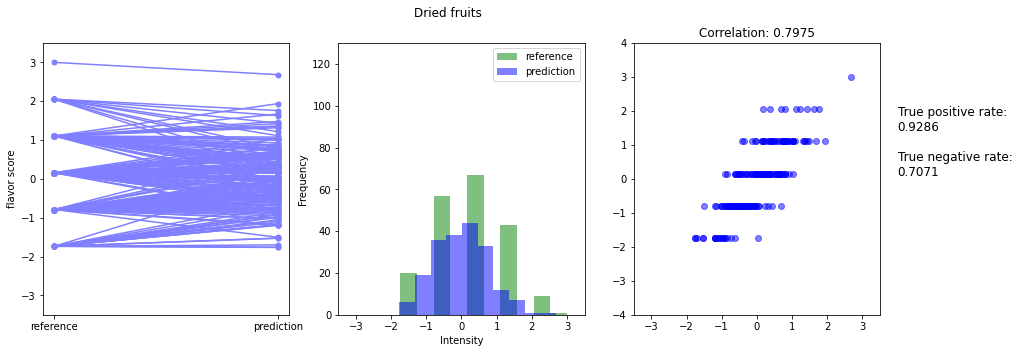

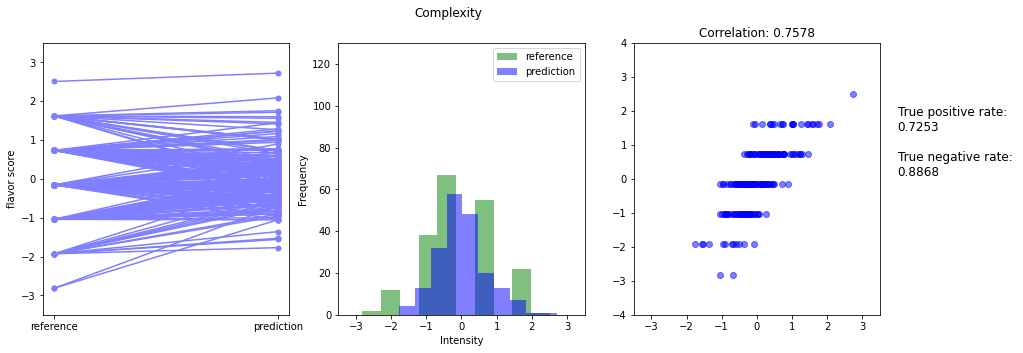

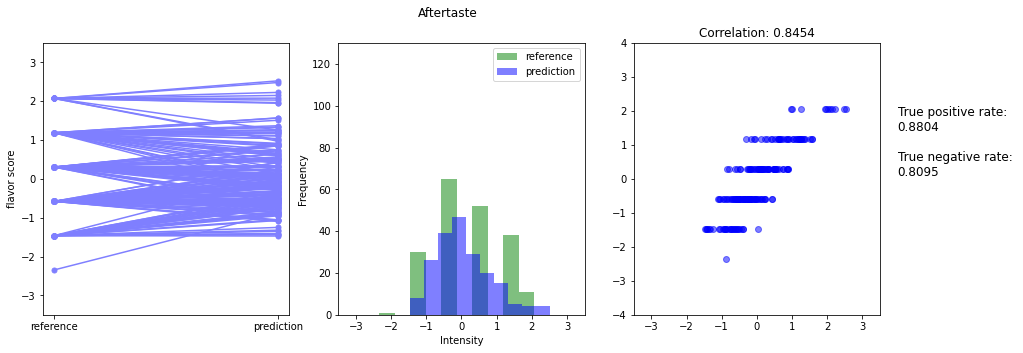

In [11]:
show_correlation_pred_extend(prediction_sweet, panelist_df_norm['Sweet'],"Sweet")
show_correlation_pred_extend(prediction_fruity,panelist_df_norm['Fruity'],"Fruity")
show_correlation_pred_extend(prediction_woody,panelist_df_norm['Woody'],"Woody")
show_correlation_pred_extend(prediction_malt,panelist_df_norm['Malt'],"Malt")
show_correlation_pred_extend(prediction_floral,panelist_df_norm['Floral'],"Floral")
show_correlation_pred_extend(prediction_peaty,panelist_df_norm['Peaty'],"Peaty")
show_correlation_pred_extend(prediction_dried_fruits,panelist_df_norm['Dried_fruits'],"Dried fruits")
show_correlation_pred_extend(prediction_complexity,panelist_df_norm['Complexity'],"Complexity")
show_correlation_pred_extend(prediction_aftertaste,panelist_df_norm['Aftertaste'],"Aftertaste")


#### Flavornet labeled molecules (Sweet, fruity, woody)

In [16]:
# find cas numbers for these molecules# all molecules that where labeled as sweet in flavornet
sweet_descriptors = ["benzyl alcohol","ethyl phenylacetate","tridecanal","nerol","methyl hexanoate","linalyl isovalerate","undecanaldehyde","caryophyllene oxide","linalyl acetate","safranal","uncineol","phenylethanal","p-anisaldehyde","eudesmol","ethylmethyl pyrazine","citronellyl butyrate","4-methyl-3-penten-2-one","nonyl acetate","10-epi-γ-eudesmol","β-bisabolol","(Z)-6-dodecene-γ-lactone","β-farnesene","2-dodecenal","γ-dodecalactone","epoxy-β-ionone","2-undecenal","styrene glycol","methyl furaneol","(-)-cis-rose oxide","(E)-β-ocimene","dimethylmethoxyfuranone","1,8-cineole","ethylbenzaldehyde","2-pentylthiophene","α-farnesene","methionol","7-methoxycoumarin","(Z)-3-hexenyl-2-methylbutanoate","o-aminoacetophenone","viridiflorol","isopiperitone","β-sinensal","ethyl vanillate","methyl butanoate","p-methoxystyrene","ethanol","6-Methoxyeugenol","4-hexanolide","δ-dodecalactone","sesquiphellandrene","diethyl malate","linalyl butyrate","guaiacol","coumarin","methyl benzoate","isopropyl benzoate","safrole","durene","γ-butyrolactone","ethyl isobutyrate","furfural"]
fruit_descriptors = ["ethyl phenylacetate", "geranyl valerate", "γ-heptalactone", "ethyl propionate", "diethyl acetal", "geranyl butyrate", "ethyl heptylate", "ethyl octanoate", "methyl hexanoate", "dimethylheptenal", "pentanone", "ethyl 3-methylbutanoate", "geranyl isovalerate", "isobutyl acetate", "ethoxypropanol", "methyl-2-butenal", "methylnonanedione", "linalyl acetate", "methyl geranate", "limonene oxide", "hydrocinnamic alcohol", "diethyl succinate", "ethyl hexanoate", "ethylmethyl pyrazine", "β-cubebene", "neryl acetate", "citronellyl butyrate", "hexyl acetate", "nonyl acetate", "butyl methylbutyrate", "pentenal", "isopentyldimethylpyrazine", "p-menth-1-en-9-ol", "hexadecanone", "octyl acetate", "γ-dodecalactone", "epoxy-β-ionone", "ethyl octenoate", "ethyl isohexanoate", "isobornyl propionate", "cedrenol", "p-menth-1-en-9-yl acetate", "cadinadiene", "(Z)-3-hexenyl hexanoate", "ethyl cyclohexanoate", "4-methylthio-2-butanone", "3,5-octadienone", "methyl cyclohexanecarboxylate", "2-pentylthiophene", "α-ocimene", "butanediol", "ethyl valerate", "pentanol", "isopiperitone", "butyl octanoate", "ethyl vanillate", "methyl butanoate", "2-methylbutyl acetate", "propyl hexanoate", "butyl hexanoate", "isopropyl butanoate", "spathulenol", "butanol", "δ-dodecalactone", "methyl quinoxaline", "sesquiphellandrene", "2-hexenol", "ethyl benzoate", "isopropyl benzoate", "ethyl lactate", "citronellyl isobutyrate"]
wood_descriptors = ["α-muurolene","cadina-1,4-dien-3-ol","isocaryophyllene","eudesmol","α-ionone","bornyl butyrate","(E)-α-bergamotene","linalool oxide","ethyl pyrazine","10-epi-γ-eudesmol","germacrene B","trans-sabinene hydrate","dihydrolinalool","isodihydrocarveol","β-farnesene","β-sesquiphellandrene","δ-elemene","α-calacorene","epoxy-β-ionone","germacrene D","bicyclogermacrene","alloaromadendrene","α-thujene","oxo-β-ionone","(-)-γ-elemene","γ-muurolene","sabinene","α-guaiene","α-copaene","γ-cadinene","nerolidol","β-eudesmol","α-cadinol","δ-cadinene","dill apiol","aromadendrene","α-gurjunene","guaiol","α-farnesene","γ-selinene","cuminica lcohol","perillen","elemol","α-humulene","β-caryophyllene","β-guaiene"]
malt_descriptors = ["pentanal","3-methyl-1-butanol","2-methyl-1-butanol","methylbutanal","isobutyraldehyde"]

sweet_descriptors_CAS = [CAS_to_mol.loc[index]["CAS"]for index in sweet_descriptors if index in CAS_to_mol.index ]
fruit_descriptors_CAS = [CAS_to_mol.loc[index]["CAS"] for index in fruit_descriptors if index in CAS_to_mol.index]
wood_descriptors_CAS = [CAS_to_mol.loc[index]["CAS"] for index in wood_descriptors if index in CAS_to_mol.index]
malt_descriptors_CAS  =[CAS_to_mol.loc[index]["CAS"] for index in malt_descriptors if index in CAS_to_mol.index]

In [17]:
fn_sweet_df = ms_data_comp[sweet_descriptors_CAS]
fn_fruity_df = ms_data_comp[fruit_descriptors_CAS]
fn_woody_df = ms_data_comp[wood_descriptors_CAS]

In [18]:
p_sweet_fn, prediction_sweet_fn = find_best_params(np.array( fn_sweet_df),np.array(panelist_df_norm['Sweet']))
p_fruity_fn, prediction_fruity_fn = find_best_params(np.array( fn_fruity_df),np.array(panelist_df_norm['Fruity']))
p_woody_fn, prediction_woody_fn = find_best_params(np.array( fn_woody_df ),np.array(panelist_df_norm['Woody']))


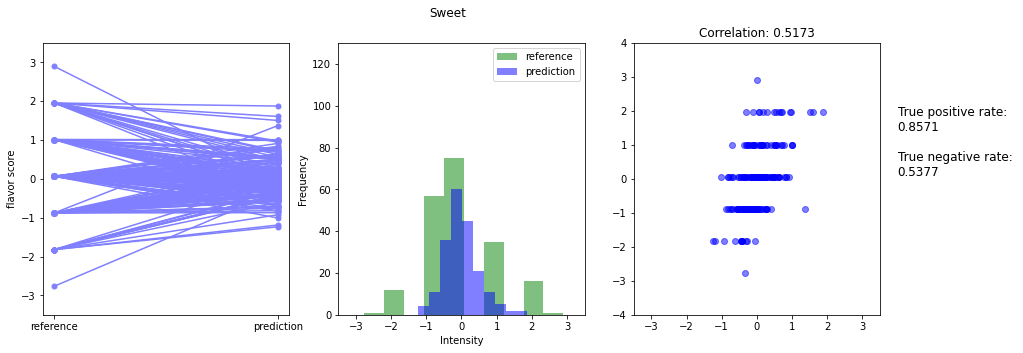

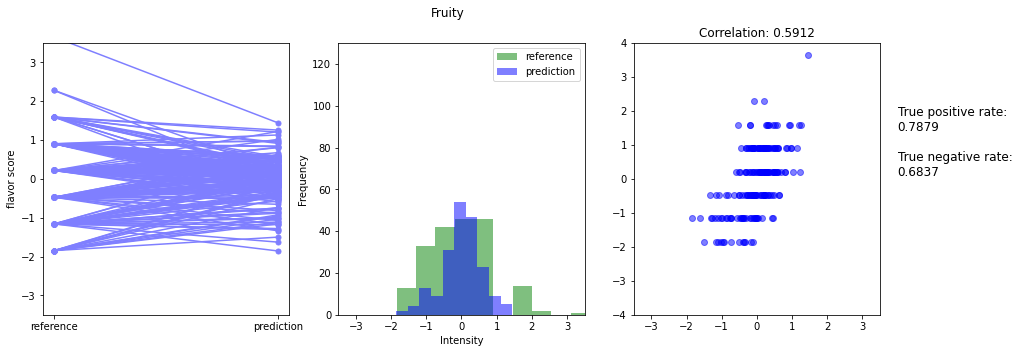

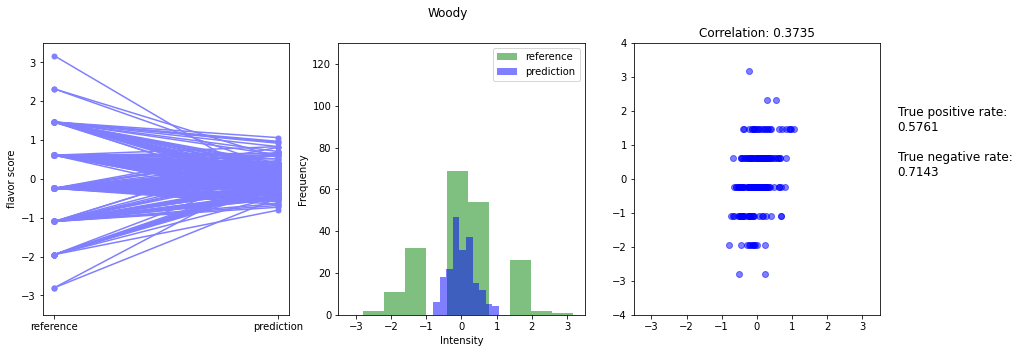

In [19]:
show_correlation_pred_extend(prediction_sweet_fn,np.array(panelist_df_norm['Sweet']),"Sweet")
show_correlation_pred_extend(prediction_fruity_fn,np.array(panelist_df_norm['Fruity']),"Fruity")
show_correlation_pred_extend(prediction_woody_fn,np.array(panelist_df_norm['Woody']),"Woody")


In [22]:
# data from statistical analysis
sweet_sig_CAS = ['101-97-3', '10486-19-8', '106-25-2', '106-70-7', '1118-27-0', '1139-30-6', '115-95-7', '1209-71-8', '122-78-1', '123-11-5', '123123-38-6', '141-16-2', '15051-81-7', '15352-77-9', '18679-18-0', '18794-84-8', '20407-84-5', '07.05.2305', '23267-57-4', '27538-09-6', '3033-23-6', '3779-61-1', '4077-47-8', '470-82-6', '4861-58-9', '502-61-4', '531-59-9', '552-02-3', '60066-88-8', '617-05-0', '623-42-7', '6627-88-9', '695-06-7', '713-95-1', '73744-93-1', '03.12.7554', '78-36-4', '90-05-1', '93-58-3', '939-48-0', '94-59-7', '97-62-1']
significant_CAS_all_sweet = ['3033-23-6', '21284-22-0', '38427-78-0', '495-61-4', '29873-99-2', '876-17-5', '5989-27-5', '4674-50-4', '2243-33-6', '10307-61-6', '13419-69-7', '928-95-0', '928-97-2', '14371-10-9', '106-28-5', '5273-85-8', '5932-68-3', '07.11.5258', '13474-59-4', '23726-91-2', '3779-61-1', '4128-17-0', '1117-52-8', '92356-06-4', '928-96-1', '31501-11-8', '21662-09-9', '15456-69-6', '18679-18-0', '3790-78-1', '3338-55-4', '491-04-3', '28973-97-9', '4798-44-1', '562-74-3', '470-67-7', '83861-74-9', '359794-78-8', '470-82-6', '15051-81-7', '75853-49-5', '1072-83-9', '2497-25-8', '3913-71-1', '3913-81-3', '20407-84-5', '104-76-7', '928-94-9', '624-41-9', '123-96-6', '20664-46-4', '2548-87-0', '2363-89-5', '4861-58-9', '600-14-6', '04.02.4313', '05.03.4313', '30361-28-5', '13360-65-1', '136954-20-6', '7774-73-4', '31823-43-5', '1669-44-9', '51193-77-2', '34318-21-3', '586-82-3', '38284-27-4', '695-06-7', '19872-52-7', '818-49-5', '693-95-8', '34047-39-7', '2785-87-7', '2628-17-3', '13925-05-8', '620-02-0', '698-76-0', '67-47-0', '105683-99-6', '147159-48-6', '6627-88-9', '54290-12-9', '531-59-9', '698-10-2', '98-86-2', '498-02-2', '1192-62-7', '85213-22-5', '88-15-3', '25246-27-9', '489-39-4', '29887-38-5', '18607-93-7', '120-51-4', '103-37-7', '4430-42-6', '24703-35-3', '28588-75-2', '507-70-0', '26927-90-2', '13109-70-1', '7492-41-3', '76-50-6', '22451-73-6', '123-86-4', '136-60-7', '106-18-3', '24168-70-5', '114791-16-1', '29837-12-5', '483-77-2', '79-92-5', '465-31-6', '142-62-1', '97-42-7', '1139-30-6', '28231-03-0', '36653-82-4', '140-10-3', '15537-55-0', '106-23-0', '150-84-5', '141-16-2', '97-89-2', '7540-53-6', '122-03-2', '124-18-5', '69134-53-8', '105-57-7', '03.12.7554', '123-25-1', '87-91-2', '619-01-2', '20777-49-5', '58985-18-5', '484-31-1', '5756-24-1', '3658-80-8', '13925-07-0', '55764-23-3', '4077-47-8', '487-11-6', '639-99-6', '128386-31-2', '134346-43-3', '23267-57-4', '140-67-0', '157615-33-3', '181589-32-2', '111-35-3', '4192-77-2', '3025-30-7', '110516-60-4', '5405-41-4', '108-64-5', '105-54-4', '103-36-6', '2021-28-5', '628-97-7', '999-10-0', '97-62-1', '97-64-3', '7452-79-1', '101-97-3', '105-37-3', '118-61-6', '124-06-1', '539-82-2', '617-05-0', '15707-34-3', '123123-38-6', '97-53-0', '1632-73-1', '102322-83-8', '13679-70-4', '98-02-2', '19700-21-1', '106-24-1', '105-87-3', '3796-70-1', '106-29-6', '109-20-6', '10402-47-8', '15423-57-1', '23986-74-5', '90-05-1', '489-86-1', '629-78-7', '111-71-7', '142-82-5', '589-82-2', '111-70-6', '543-49-7', '110-43-0', '544-76-3', '29354-98-1', '18787-63-8', '66-25-1', '111-31-9', '111-27-3', '591-78-6', '589-38-8', '3681-71-8', '27538-10-9', '19888-33-6', '122-97-4', '95908-33-1', '21835-00-7', '3142-66-3', '5704-20-1', '123-92-2', '124-76-5', '1200-67-5', '2756-56-1', '110-19-0', '24683-00-9', '118-65-0', '18675-35-9', '97-54-1', '16750-94-0', '5944-20-7', '18433-98-2', '939-48-0', '638-11-9', '142-91-6', '89-49-6', '503-74-2', '498-16-8', '23089-26-1', '138-86-3', '78-70-6', '115-95-7', '78-36-4', '115-99-1', '1118-27-0', '10471-96-2', '89-80-5', '10458-14-7', '40789-98-8', '34300-94-2', '50746-10-6', '75832-79-0', '67633-97-0', '17042-24-9', '3268-49-3', '16630-66-3', '95-63-6', '2527-76-6', '93-58-3', '623-42-7', '1754-62-7', '103-26-4', '4630-82-4', '39647-11-5', '93-15-2', '27538-09-6', '1189-09-9', '106-70-7', '1211-29-6', '556-24-1', '868-57-5', '547-63-7', '112-61-8', '124-10-7', '3943-74-6', '5287-45-6', '116-53-0', '65128-99-6', '26486-13-5', '13679-85-1', '5616-51-3', '28588-74-1', '59303-05-8', '110-93-0', '590-36-3', '565-69-5', '26548-78-7', '123-35-3', '607-91-0', '91-20-3', '106-25-2', '40716-66-3', '141-12-8', '629-92-5', '124-19-6', '111-84-2', '821-55-6', '19322-27-1', '27400-71-1', '502-99-8', '638-66-4', '593-45-3', '65767-22-8', '124-13-0', '111-65-9', '111-87-5', '589-98-0', '111-13-7', '106-68-3', '18409-17-1', '3391-86-4', '4312-99-6', '29790-29-2', '619-62-5', '123-11-5', '501-98-4', '18479-68-0', '28839-13-6', '629-80-1', '599-04-2', '09.11.2765', '629-62-9', '109-52-4', '502-69-2', '103-82-2', '122-78-1', '97-47-3', '16721-39-4', '105-66-8', '106-36-5', '5471-51-2', '3387-41-5', '94-59-7', '73744-93-1', '83-34-1', '28664-35-9', '6750-60-3', '112-92-5', '100-42-5', '91-10-1', '19912-62-0', '80-26-2', '629-59-4', '124-25-4', '6258-63-5', '17699-16-0', '638-67-5', '10486-19-8', '81018-77-1', '57461-21-9', '1209-71-8', '03.07.4630', '552-02-3', '182699-77-0', '58334-55-7', '515-69-5', '481-34-5', '4586-22-5', '3856-25-5', '17699-14-8', '644-30-4', '502-61-4', '14575-74-7', '01.12.3691', '489-40-7', '6753-98-6', '127-41-3', '10208-80-7', '1195-32-0', '99-83-2', '80-56-8', '99-86-5', '98-55-5', '02.05.2867', '495-60-3', '15352-77-9', '554-60-9', '87-44-5', '472-97-9', '13744-15-5', '23726-93-4', '33880-83-0', '473-15-4', '18794-84-8', '58181-76-3', '88-84-6', '79-77-6', '555-10-2', '103-45-7', '127-91-3', '17066-67-0', '20307-83-9', '60066-88-8', '138-87-4', '39029-41-9', '07.05.2305', '105-21-5', '30021-74-0', '104-50-7', '515-17-3', '99-85-4', '13466-78-9', '483-76-1', '36564-42-8', '713-95-1', '20307-84-0', '120021-96-7', '586-62-9']
fruity_sig_CAS = ['10402-47-8', '105-21-5', '106-29-6', '106-32-1', '106-70-7', '108-64-5', '109-20-6', '1189-09-9', '13360-64-0', '2051-50-5', '2756-56-1', '38284-27-4', '539-82-2', '589-75-3', '624-41-9', '626-82-4', '638-11-9']
significant_CAS_all_fruity = ['21284-22-0', '10307-61-6', '106-28-5', '23726-91-2', '4128-17-0', '1117-52-8', '3790-78-1', '15051-81-7', '20407-84-5', '104-76-7', '100-71-0', '578-58-5', '624-41-9', '123-96-6', '60-12-8', '04.02.4313', '05.03.4313', '30361-28-5', '51755-83-0', '38284-27-4', '122-00-9', '31539-84-1', '620-02-0', '6627-88-9', '54290-12-9', '1192-62-7', '22047-25-2', '18607-93-7', '100-52-7', '65-85-0', '95-16-9', '538-86-3', '26927-90-2', '13109-70-1', '76-50-6', '22451-73-6', '626-82-4', '589-75-3', '97-42-7', '501-92-8', '104-54-1', '72203-97-5', '334-48-5', '112-17-4', '30364-38-6', '23747-48-0', '484-31-1', '5756-24-1', '55764-23-3', '95-93-2', '639-99-6', '134346-43-3', '108-64-5', '110-38-3', '19788-49-9', '7452-79-1', '106-32-1', '539-82-2', '4748-78-1', '13360-64-0', '620-17-7', '123123-38-6', '19700-21-1', '3796-70-1', '106-29-6', '109-20-6', '10402-47-8', '90-05-1', '489-86-1', '50862-12-9', '2639-63-6', '6378-65-0', '123-92-2', '1200-67-5', '2756-56-1', '638-11-9', '143-07-7', '23089-26-1', '78-36-4', '115-99-1', '1118-27-0', '10471-96-2', '108-38-3', '505-10-2', '94087-83-9', '2527-76-6', '1189-09-9', '106-70-7', '1211-29-6', '1731-84-6', '3943-74-6', '15707-23-0', '33504-66-4', '59303-05-8', '52558-99-3', '607-91-0', '91-20-3', '40716-66-3', '111-84-2', '551-93-9', '95-47-6', '65767-22-8', '124-13-0', '111-87-5', '589-98-0', '111-13-7', '106-68-3', '18409-17-1', '3391-86-4', '2051-50-5', '99-87-6', '123-07-9', '18368-95-1', '637-69-4', '599-04-2', '68039-26-9', '105-66-8', '28664-35-9', '19912-62-0', '6258-63-5', '638-67-5', '112-70-9', '14667-55-1', '1209-71-8', '112-42-5', '552-02-3', '58334-55-7', '515-69-5', '481-34-5', '21391-99-1', '4586-22-5', '127-41-3', '15352-77-9', '472-97-9', '473-15-4', '58181-76-3', '79-77-6', '105-21-5', '36564-42-8']
woody_sig_CAS = ['10208-80-7', '114791-16-1', '118-65-0', '123123-38-6', '127-41-3', '13109-70-1', '13474-59-4', '1365-19-1', '15051-81-7', '15423-57-1', '17699-16-0', '18675-35-9', '18794-84-8', '20307-83-9', '20307-84-0', '23267-57-4', '23986-74-5', '24703-35-3', '25246-27-9', '02.05.2867', '29790-29-2', '29873-99-2', '30021-74-0', '3387-41-5', '01.12.3691', '3856-25-5', '39029-41-9', '40716-66-3', '473-15-4', '481-34-5', '483-76-1', '484-31-1', '489-39-4', '489-40-7', '489-86-1', '502-61-4', '515-17-3', '639-99-6', '6753-98-6', '87-44-5', '88-84-6']
significant_CAS_all_woody = ['3033-23-6', '21284-22-0', '38427-78-0', '495-61-4', '29873-99-2', '6909-30-4', '876-17-5', '5989-27-5', '4674-50-4', '2243-33-6', '10307-61-6', '928-95-0', '53448-07-0', '928-97-2', '1197-07-5', '14371-10-9', '09.04.5948', '106-28-5', '5273-85-8', '5932-68-3', '4959-35-7', '34995-77-2', '7212-40-0', '07.11.5258', '13474-59-4', '23726-91-2', '3779-61-1', '4128-17-0', '1117-52-8', '21661-99-4', '92356-06-4', '928-96-1', '16491-36-4', '31501-11-8', '21662-09-9', '15456-69-6', '18679-18-0', '1197-06-4', '3792-53-8', '13837-75-7', '5989-33-3', '3790-78-1', '3338-55-4', '491-04-3', '28973-97-9', '4798-44-1', '562-74-3', '470-67-7', '470-82-6', '15051-81-7', '75853-49-5', '1072-83-9', '2497-25-8', '3913-71-1', '3913-81-3', '20407-84-5', '104-76-7', '100-71-0', '928-94-9', '19846-22-1', '578-58-5', '624-41-9', '123-96-6', '4861-58-9', '60-12-8', '2463-77-6', '92760-25-3', '600-14-6', '65909-91-3', '04.03.6750', '5910-87-2', '13360-65-1', '557-48-2', '136954-20-6', '7774-73-4', '31823-43-5', '34318-21-3', '586-82-3', '21944-83-2', '1126-51-8', '2785-89-9', '19872-52-7', '818-49-5', '2785-87-7', '2628-17-3', '59121-25-4', '13925-05-8', '698-76-0', '105683-99-6', '147159-48-6', '6627-88-9', '531-59-9', '698-10-2', '98-86-2', '498-02-2', '70286-20-3', '4166-20-5', '22047-25-2', '1122-62-9', '85213-22-5', '55041-85-5', '29926-41-8', '25246-27-9', '489-39-4', '29887-38-5', '546-49-6', '18607-93-7', '65-85-0', '95-16-9', '120-51-4', '103-37-7', '538-86-3', '24703-35-3', '28588-75-2', '507-70-0', '26927-90-2', '13109-70-1', '7492-41-3', '10395-54-7', '22451-73-6', '123-86-4', '136-60-7', '626-82-4', '106-18-3', '15706-73-7', '24168-70-5', '114791-16-1', '29837-12-5', '483-77-2', '79-92-5', '465-31-6', '76-22-2', '142-62-1', '99-48-9', '97-42-7', '1139-30-6', '28231-03-0', '36653-82-4', '72203-97-5', '14009-71-3', '15537-55-0', '5392-40-5', '106-23-0', '150-84-5', '141-16-2', '97-89-2', '25152-84-5', '25152-83-4', '124-18-5', '334-48-5', '112-30-1', '30364-38-6', '69134-53-8', '03.12.7554', '105-53-3', '123-25-1', '87-91-2', '619-01-2', '20777-49-5', '58985-18-5', '484-31-1', '131092-10-9', '5756-24-1', '13925-07-0', '55764-23-3', '4077-47-8', '72203-98-6', '541-58-2', '3581-91-7', '112-40-3', '487-11-6', '639-99-6', '134454-31-2', '128386-31-2', '134346-43-3', '13955-48-1', '23267-57-4', '14049-11-7', '157615-33-3', '4192-77-2', '3025-30-7', '110516-60-4', '5405-41-4', '108-64-5', '105-54-4', '103-36-6', '2021-28-5', '106-30-9', '999-10-0', '97-62-1', '7452-79-1', '106-32-1', '101-97-3', '118-61-6', '124-06-1', '539-82-2', '617-05-0', '15707-34-3', '38205-61-7', '2305-25-1', '13360-64-0', '620-17-7', '123123-38-6', '97-53-0', '1632-73-1', '57500-00-2', '19700-21-1', '141-27-5', '106-24-1', '105-87-3', '3796-70-1', '106-29-6', '15423-57-1', '23986-74-5', '489-86-1', '629-94-7', '142-82-5', '589-82-2', '111-70-6', '543-49-7', '544-76-3', '29354-98-1', '66-25-1', '591-78-6', '589-38-8', '3681-71-8', '2639-63-6', '27538-10-9', '20053-88-7', '19888-33-6', '122-97-4', '95908-33-1', '123-92-2', '124-76-5', '1200-67-5', '2756-56-1', '110-19-0', '18640-74-9', '24683-00-9', '118-65-0', '18675-35-9', '97-54-1', '16750-94-0', '5944-20-7', '18433-98-2', '58615-39-7', '939-48-0', '638-11-9', '2311-46-8', '25773-40-4', '89-49-6', '498-16-8', '23089-26-1', '138-86-3', '1195-92-2', '78-70-6', '1365-19-1', '115-95-7', '78-36-4', '115-99-1', '89-80-5', '10458-14-7', '75832-79-0', '65505-17-1', '16630-66-3', '95-63-6', '2527-76-6', '93-58-3', '1754-62-7', '103-26-4', '4630-82-4', '39647-11-5', '95722-42-2', '93-15-2', '27538-09-6', '1189-09-9', '106-70-7', '1211-29-6', '556-24-1', '868-57-5', '1731-84-6', '111-11-5', '119-36-8', '124-10-7', '3943-74-6', '65128-99-6', '26486-13-5', '13679-85-1', '5616-51-3', '15707-23-0', '33504-66-4', '59303-05-8', '2371-42-8', '113486-29-6', '565-69-5', '52558-99-3', '123-35-3', '607-91-0', '91-20-3', '106-26-3', '106-25-2', '1786-08-9', '40716-66-3', '141-12-8', '629-92-5', '124-19-6', '111-84-2', '112-05-0', '821-55-6', '551-93-9', '27400-71-1', '502-99-8', '638-66-4', '593-45-3', '124-13-0', '111-87-5', '589-98-0', '111-13-7', '106-68-3', '18409-17-1', '3391-86-4', '2051-50-5', '29790-29-2', '43160-78-7', '619-62-5', '123-11-5', '105-13-5', '501-98-4', '123-07-9', '18479-68-0', '28839-13-6', '32495-14-0', '94268-57-2', '77026-83-6', '77026-84-7', '71159-90-5', '599-04-2', '09.11.2765', '629-62-9', '540-18-1', '68039-26-9', '3777-69-3', '2294-76-0', '502-69-2', '103-82-2', '122-78-1', '97-47-3', '4410-99-5', '150-86-7', '168564-54-3', '4955-29-7', '16721-39-4', '89-81-6', '105-66-8', '626-77-7', '106-36-5', '54814-64-1', '5471-51-2', '3387-41-5', '94-59-7', '73744-93-1', '83-34-1', '28664-35-9', '6750-60-3', '112-92-5', '25779-13-9', '91-10-1', '19912-62-0', '80-26-2', '629-59-4', '124-25-4', '6258-63-5', '17699-16-0', '638-67-5', '10486-19-8', '14667-55-1', '81018-77-1', '57461-21-9', '1209-71-8', '112-44-7', '112-42-5', '112-12-9', '03.07.4630', '121-33-5', '552-02-3', '182699-77-0', '58334-55-7', '515-69-5', '481-34-5', '4586-22-5', '3856-25-5', '17699-14-8', '644-30-4', '502-61-4', '14575-74-7', '01.12.3691', '489-40-7', '6753-98-6', '127-41-3', '10208-80-7', '1195-32-0', '99-83-2', '80-56-8', '99-86-5', '98-55-5', '02.05.2867', '495-60-3', '15352-77-9', '554-60-9', '87-44-5', '472-97-9', '13744-15-5', '432-25-7', '23726-93-4', '33880-83-0', '473-15-4', '18794-84-8', '58181-76-3', '88-84-6', '79-77-6', '555-10-2', '103-45-7', '127-91-3', '17066-67-0', '20307-83-9', '60066-88-8', '138-87-4', '39029-41-9', '706-14-9', '07.05.2305', '105-21-5', '30021-74-0', '104-50-7', '515-17-3', '99-85-4', '13466-78-9', '483-76-1', '36564-42-8', '705-86-2', '2825-91-4', '713-95-1', '20307-84-0', '120021-96-7', '586-62-9']

### new labeled molecules

In [24]:
#SUMMARY: 
print('significant molecules')
print("FN Sweet: " + str(len(sweet_sig_CAS)))
print("all Sweet: " + str(len(significant_CAS_all_sweet)))
print("FN Fruity: " + str(len(fruity_sig_CAS)))
print("all Fruity: " + str(len(significant_CAS_all_fruity)))
print("FN Woody: " + str(len(woody_sig_CAS)))
print("all Woody: " + str(len(significant_CAS_all_woody)))

significant molecules
FN Sweet: 42
all Sweet: 398
FN Fruity: 17
all Fruity: 139
FN Woody: 41
all Woody: 444


In [25]:
new_sweet_df = ms_data_comp[significant_CAS_all_sweet]
new_fruity_df = ms_data_comp[significant_CAS_all_fruity]
new_woody_df = ms_data_comp[significant_CAS_all_woody]

In [26]:
p_sweet_new, prediction_sweet_new = find_best_params(np.array( new_sweet_df ),np.array(panelist_df_norm['Sweet']))
p_fruity_new, prediction_fruity_new = find_best_params(np.array( new_fruity_df),np.array(panelist_df_norm['Fruity']))
p_woody_new, prediction_woody_new = find_best_params(np.array( new_woody_df ),np.array(panelist_df_norm['Woody']))


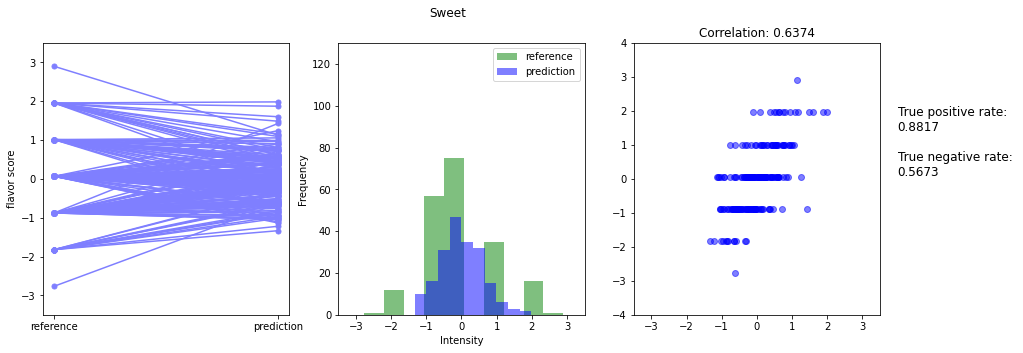

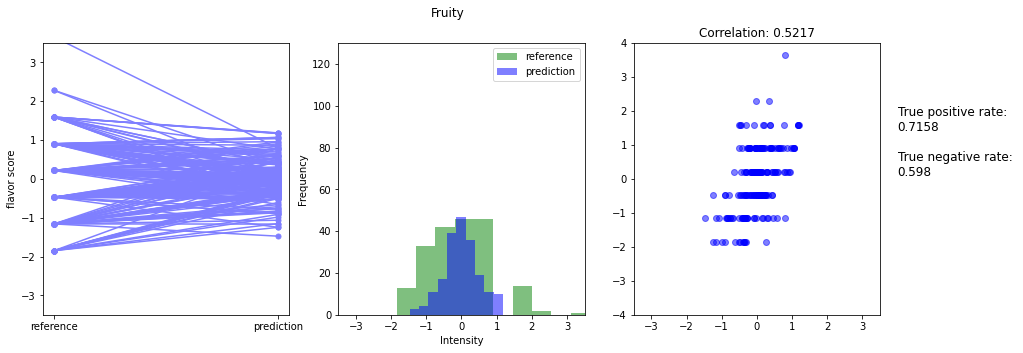

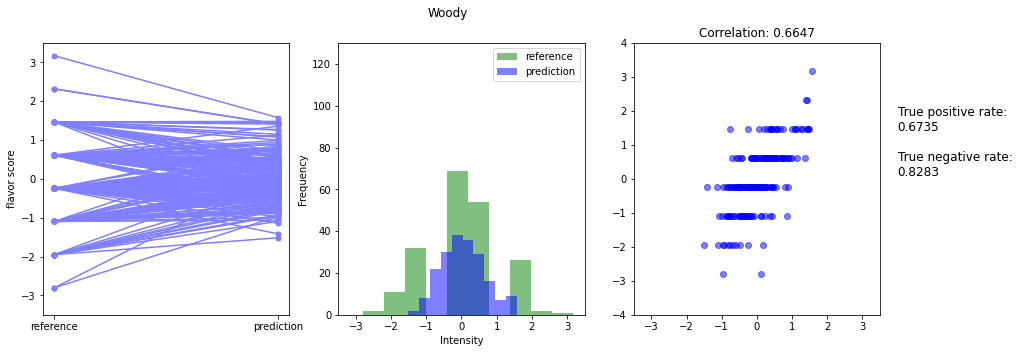

In [27]:
show_correlation_pred_extend(prediction_sweet_new,np.array(panelist_df_norm['Sweet']),"Sweet")
show_correlation_pred_extend(prediction_fruity_new,np.array(panelist_df_norm['Fruity']),"Fruity")
show_correlation_pred_extend(prediction_woody_new,np.array(panelist_df_norm['Woody']),"Woody")
